In [1]:
import cupy as cp
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
cp.random.seed(180)

### Quick Recap
1. Training data contains features and label that is a real number
2. Model or inference: $\bf y=Xw$

In [3]:
# Create a dataset of 100 examples with a single feature and a label.
# For this conversation, we use the following three parameters
w1 = 3
w0 = 4
n = 100

x = 10*cp.random.randn(n,)

# Obtain y = 4 + 3*x + noise. Noise is randomly sampled.
y = w0 + w1*x + cp.random.randn(n,)

Lets examine the shapes of the data for sanity check

In [4]:
print("Shape of training data feature matrix: ", x.shape)
print("Shape of target vector:", y.shape)

Shape of training data feature matrix:  (100,)
Shape of target vector: (100,)


Let's divide the data into training and test set. We will set aside 20% of the examples for testing

In [6]:
from cuml import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Let's do a quick sanity check to make sure the sizes of features and target sets are identical in both training and test data.

In [7]:
print('Shape of training feature matrix:', X_train.shape)
print('Shape of training label vector:', y_train.shape)

print('Shape of test feature matrix:', X_test.shape)
print('Shape of test label matrix:', y_test.shape)

Shape of training feature matrix: (80,)
Shape of training label vector: (80,)
Shape of test feature matrix: (20,)
Shape of test label matrix: (20,)


Let's quickly check the first few examples and labels

In [8]:
display(X_train[:5])
display(y[:5])

array([ -8.35364802, -12.14206044,  -6.56057812, -15.23653087,
         1.73798644])

array([ 17.45645391,  43.5217927 , -25.36421206,  23.29849409,
        27.5744419 ])

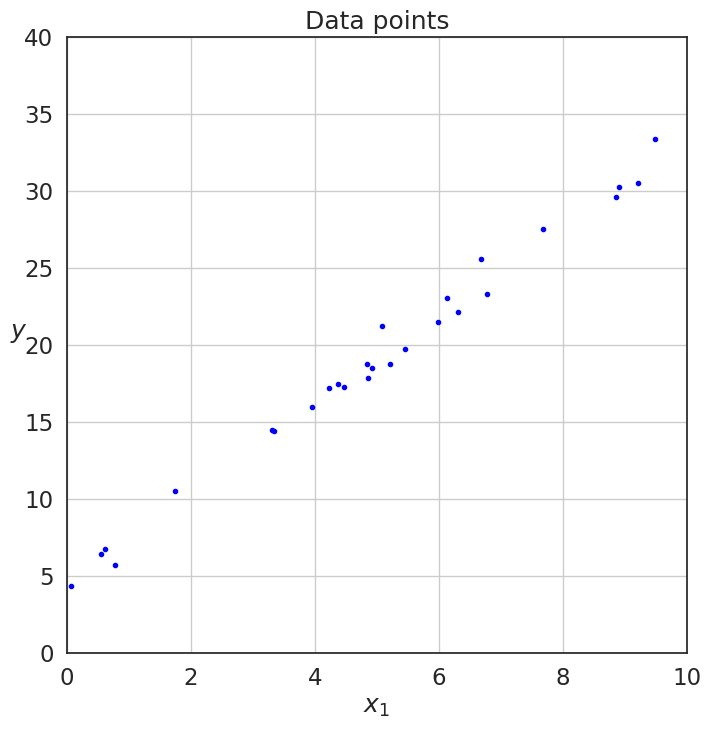

In [ ]:
sns.set_style("white")
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={'lines.linewidth': 2.5})

plt.plot(X_train.get(), y_train.get(), "b.") # Converting cupy array to numpy array
plt.title("Data points")
plt.grid(True)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 10, 0, 40])

plt.show()

We have a training set consisting of a single feature so we will fit a simple linear regression model with one feature. It's form is : $y=w_0+w_1x_1$

As discussed in the lecture, we will add a special feature $x_0$ and set it to 1. We can create a helper function for that.

In [11]:
def add_dummy_feature(x):
    ''' Adds a dummy feature to the dataset.
    Args:
        x: Training dataset
    Returns:
        Training dataset with an addition of dummy feature.
    '''
    # cp.ones(X.shape[0]) create a vector of 1's having the same number of 
    # rows as number of samples in dataset.
    return cp.column_stack((cp.ones(x.shape[0]), x))

Let's write a test case to test this function:

For that let's take a two examples and three features. The first example is a feature vector:
$$\textbf{x}_{3\times1}^{(1)} = \begin{bmatrix} 3 \\ 2 \\ 5 \end{bmatrix}$$

And the second example is:
$$\textbf{x}_{3\times1}^{(2)} = \begin{bmatrix} 9 \\ 4 \\ 7 \end{bmatrix}$$

And recall that a feature matrix $\bf X$  has a shape *(n,m)* corresponding to features of all examples before adding the dummy feature $x_0$.
$$\textbf{X}_{n\times m} = \begin{bmatrix} {-(x^{(1)})^T-} \\ {-(x^{(2)})^T-} \\ . \\ . \\ . \\ {-(x^{(n)})^T-} \end{bmatrix}$$

In our current example, this becomes:
$$\textbf{X}_{2\times3} = \begin{bmatrix} {-(x^{(1)})^T-} \\ {-(x^{(2)})^T-} \end{bmatrix}$$


The corresponding feature matrix $\bf X$ appears as follows:
$$\textbf{X}_{2\times3} = \begin{bmatrix} 3 & 2 & 5 \\ 9 & 4 & 7 \end{bmatrix}$$

Here the feature vectors are transposed an represented as rows:
- The first row corresponds to the first example $(\textbf{x}^{(1)})^T$ and 
- The second row corresponds to the second example $(\textbf{x}^{(2)})^T$.


Once we add the dummy feature , the resulting matrix becomes:
$$\textbf{X}_{2\times(3+1)} = \begin{bmatrix} {-(x^{(1)})^T-} \\ {-(x^{(2)})^T-} \end{bmatrix} = \begin{bmatrix} 1 & 3 & 2 & 5 \\ 1 & 9 & 4 & 7 \end{bmatrix}$$

In [12]:
import unittest

class TestAddDummyFeature(unittest.TestCase):

    def test_add_dummy_feature(self):
        """Test case function for add_dummy_feature"""
        train_matrix = cp.array([[3, 4, 5], [9, 4, 7]])
        train_matrix_with_dummy_feature = add_dummy_feature(train_matrix)

        #Test the shape
        self.assertEqual(train_matrix_with_dummy_feature.shape, (2,4))

        #and the contents
        cp.testing.assert_array_equal(train_matrix_with_dummy_feature, cp.array([[1, 3, 4, 5],[1, 9, 4, 7]]))

unittest.main(argv=[''], defaultTest='TestAddDummyFeature', verbosity=2, exit=False)

test_add_dummy_feature (__main__.TestAddDummyFeature.test_add_dummy_feature)
Test case function for add_dummy_feature ... ok

----------------------------------------------------------------------
Ran 1 test in 0.291s

OK


In [13]:
add_dummy_feature(cp.array([[3, 2],[5, 4]]))

array([[1., 3., 2.],
       [1., 5., 4.]])

Let's preprocess the training set to add the dummy feature

In [14]:
print('Before adding the dummy feature:\n', X_train[:5])
print("\n")

X_train_with_dummy = add_dummy_feature(X_train)
print('After adding the dummy feature:\n', X_train_with_dummy[:5,:])

Before adding the dummy feature:
 [ -8.35364802 -12.14206044  -6.56057812 -15.23653087   1.73798644]


After adding the dummy feature:
 [[  1.          -8.35364802]
 [  1.         -12.14206044]
 [  1.          -6.56057812]
 [  1.         -15.23653087]
 [  1.           1.73798644]]


## C2. Model

### Quick Recap
1. Training data contains features and label that is a real number
2. Linear regression model uses linear combination of features to obtain output labels.In vectorized form Model or inference: $\bf y=Xw$

**Note**:
- Model is paramterized by its weight vector.
- It is described by its mathematical form and weight vector.

### Implementation
The general vectorized form is as follows:
$$\textbf{y}_{(n\times1)}=\textbf{X}_{n\times(m+1)}\textbf{w}_{(m+1)\times1}$$
where
- $n$ is the number of examples in dataset(train/test/validation).
- $m$ is the number of features
- $\bf X$ is a feature matrix which contain $(m+1)$ features for $n$ examples along rows. (Notice capital case bold **X** used for matrix)
- $\bf w$ is a weight vector containing $(m+1)$ weights one for each feature. (Notice the small case bold **w**)
- $\bf y$ is a label vector containing labels of $n$ examples with shape $(n,)$.

In [ ]:
def predict(X,w):
    ''' Prediction of output label for a given icput.
    Args:
        X: Feature matrix of shape (n, m+1).
        w: weight vector of shape (m+1, n).
    Returns:
        y: Predicted label vector of shape (n,).
    '''
    # Check to make sure that feature matrix and weight vector  have compatible shapes.
    #print(X.shape,w.shape)
    assert X.shape[-1] == w.shape[0]
    return X @ w

We test this function with the following feature matrix $\textbf{X}_{2\times(3+1)}$
$$\textbf{X}_{2\times4} = \begin{bmatrix}
    1 & 3 & 2 & 5 \\ 1 & 9 & 4 & 7
\end{bmatrix}$$
and the weight vector $\bf w$
$$\textbf{w}_{4\times1} = \begin{bmatrix}
    1 \\ 1 \\ 1 \\ 1    
\end{bmatrix}$$
Let's perform a matrix vector multiplication between feature matrix $\bf X$ and the weight vector $\bf w$ to obtain labels for all examples:
$$\begin{align*}
    \textbf{y} 
    &= \textbf{Xw} \\
    &= \begin{bmatrix} 1 & 3 & 2 & 5 \\ 1 & 9 & 4 & 7 \end{bmatrix} \times \begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \end{bmatrix} \\
    &= \begin{bmatrix} {1\times1+3\times1+2\times1+5\times1} \\ {1\times1+9\times1+4\times1+7\times1} \end{bmatrix} \\
    &= \begin{bmatrix} 11 \\ 21 \end{bmatrix}
\end{align*}


In [17]:
import unittest

class TestPredict(unittest.TestCase):

    def test_predict(self):
        ''' Test case predict function of linear regression '''
        # set up
        train_matrix = cp.array([[1,3,2,5],[1,9,4,7]])
        weight_vector = cp.array([1,1,1,1])
        expected_label_vector = cp.array([11,21])

        #call
        predicted_label_vector = predict(train_matrix, weight_vector)

        #asserts
        #test the shape
        self.assertEqual(predicted_label_vector.shape,(2,))

        #and the contents
        cp.testing.assert_array_equal(expected_label_vector,predicted_label_vector)

unittest.main(argv=[''], defaultTest='TestPredict', verbosity=2, exit=False)


test_predict (__main__.TestPredict.test_predict)
Test case predict function of linear regression ... ok

----------------------------------------------------------------------
Ran 1 test in 1.476s

OK


In [ ]:
''' Preparing the dataset'''
[w0, w1] = [4, 3]
n = 100
x = 10 * cp.random.randn(n,)
y = w0 + w1 * x + cp.random.randn(n, )


In [19]:
''' Preprocessing: Dummy feature and train-test-split'''
X_with_dummy = add_dummy_feature(x)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_with_dummy, y, test_size=0.2, random_state=42)

print('Shape of training feature matrix:', X_train.shape)
print('Shape of training label vector:', y_train.shape)

print('Shape of test feature matrix:', X_test.shape)
print('Shape of test label matrix:', y_test.shape)

Shape of training feature matrix: (80, 2)
Shape of training label vector: (80,)
Shape of test feature matrix: (20, 2)
Shape of test label matrix: (20,)


Since we have not yet trained our model, let's use a random weight vector to get predictions from our model for a given dataset.

In [24]:
w = cp.random.rand(X_with_dummy.shape[1], )
w

array([0.29608942, 0.01114871])

In [25]:
y_hat = predict(X_train, w)

Let's compare the prediction with actual value

In [26]:
y_hat[:10]

array([0.28233656, 0.26414283, 0.28942297, 0.33605589, 0.30312514,
       0.46852799, 0.1767662 , 0.35930313, 0.3334066 , 0.3852154 ])

Actual labels are

In [27]:
y[:10]

array([ 25.46093108,  11.01006986, -22.5953873 ,  29.68261566,
        13.9459229 , -12.48028136,  31.91874673,  16.10872934,
       -51.59865948,  15.23210341])

Since we use a random weight vector $\bf w$ here, most of the predicted labels do not match the actual labels.

### Comparision of vectorized and non-vectorized version of inference.

In [ ]:
def non_vectorized_predict(X: cp.ndarray, w: cp.ndarray):
    '''Prediction of output for a given icput.
    Args:
        X: Feature matrix of shape (n, m+1)
        w: Weight vector of shape (m+1, n)
    Returns:
        y: Predicted label vector of shape (n, ).
    '''
    y = []
    for i in range(0, X.shape[0]):
        y_hat_i = 0
        for j in range(0, X.shape[1]):
            y_hat_i += X[i][j] * w[j]
        y.append(y_hat_i)
    return cp.array(y)

Let's test this function with the same setup as vectorized implementation.

In [31]:
import unittest

class TestPredictNonVectorized(unittest.TestCase):

    def test_predict_non_vectorized(self):
        '''Test case predict function of linear regression '''
        #set up
        train_matrix = cp.array([[1,3,2,5],[1,9,4,7]])
        weight_vector = cp.array([1,1,1,1])
        expected_label_vector = cp.array([11,21])

        #call
        predicted_label_vector = non_vectorized_predict(train_matrix,weight_vector)

        #asserts
        #test the shape
        self.assertEqual(predicted_label_vector.shape, (2,))

        #and its contents
        cp.testing.assert_array_equal(expected_label_vector, predicted_label_vector)

unittest.main(argv=[''],defaultTest='TestPredictNonVectorized', verbosity=2, exit=False)

test_predict_non_vectorized (__main__.TestPredictNonVectorized.test_predict_non_vectorized)
Test case predict function of linear regression ... ok

----------------------------------------------------------------------
Ran 1 test in 0.352s

OK


In [33]:
import time

start_time = time.time()
y_hat_vectorized = predict(X_train,w)
end_time = time.time()
print('Total time incurred in the vectorized inference is %0.9f s'%(end_time-start_time))

start_time = time.time()
y_hat_non_vectorized = non_vectorized_predict(X_train,w)
end_time = time.time()
print('Total time incurred in the non-vectorized inference is %0.9f s'%(end_time-start_time))

cp.testing.assert_array_equal(y_hat_vectorized,y_hat_non_vectorized)

Total time incurred in the vectorized inference is 0.000652552 s
Total time incurred in the non-vectorized inference is 0.013366938 s


In [34]:
def loss(X: cp.ndarray, y: cp.ndarray, w: cp.ndarray):
    error = predict(X, w) - y
    return 0.5 * (cp.transpose(error) @ error)

X = cp.array([[1, 2, 2, 1], [1, 1, 3, 2]])
y = cp.array([3, 5])
w = cp.array([1, 2, 3, 4]) * 2
err = loss(X, y, w)
print(err)

977.0


#### Normal equation
The weight vector is estimated by matrix multiplication of pseudo-inverse of feature matrix and label vector.

The vectorized implementation is fairly straight forward.
- We make use of ``cp.linalg.pinv`` for calculating pseudo inverse of the feature matrix

The equation is 
$$
\text{w} = (X^TX)^{-1} X^T y
$$

In [ ]:
def normal_equation(X, y):
    '''Estimates parameters of the linear regression model with normal equation
    Args:
        X: feature matrix for given icputs.
        y: Actual label vector

    Returns:
        Weight vector
    '''
    return cp.linalg.pinv(X) @ y

We test this function with generated training set whose weight vector is known to us.
- We setup the test with feature matrix, label vector and expected weight vectors
- Next we estimate the weight vector with ``normal_equation`` function.
- We test (a) shape and (ii) match between expected and estimated weight vectors. 

In [36]:
import unittest

class TestNormalEquation(unittest.TestCase):

    def test_normal_equation(self):
        '''
        Test case for weight estimation for linear regression with normal equation method
        '''

        # set up
        feature_matrix = X_train
        label_vector = y_train
        expected_weight_vector = cp.array([4.,3.])

        #call
        estimated_weight_vector = normal_equation(feature_matrix,label_vector)

        #asserts
        #test the shape
        self.assertEqual(estimated_weight_vector.shape, (2,))

        #and the contents
        cp.testing.assert_array_almost_equal(estimated_weight_vector, expected_weight_vector,decimal=0)

unittest.main(argv=[''],defaultTest='TestNormalEquation', verbosity=2, exit=False)

test_normal_equation (__main__.TestNormalEquation.test_normal_equation)
Test case for weight estimation for linear regression with normal equation method ... ok

----------------------------------------------------------------------
Ran 1 test in 0.574s

OK


### Gradient Descent(GD)
GD is implemented as follows
- Randomly initialize $w$ to 0.
- Iterate until convergence:
  - Calculate partial derivative of loss w.r.t weight vector
  - Calculate new values of weights
  - Update weights to new values simultaneously

We use number of epochs as a convergence criteria in this implementation
#### Partial derivative of loss function
Let's first implement a function to calculate partial derivative of loss function, which is obtained with the following equation:
$$\bf \frac{\partial}{\partial w}J(w) = X^T(Xw - y)$$
The multiplication of transpose of feature matrix with the difference of predicted and actual label vectors.

In [37]:
def calculate_gradient(X,y,w):
    '''Calculate gradients of loss function w.r.t weight vector on training set
    Arguments:
        X: Feature matrix for training data
        y: label vector of training data
        w: Weight vector

    Returns:
        A vector of gradients
    '''
    return cp.transpose(X) @ (predict(X,w) - y)

The equation to update the weights would be:

$$
\begin{align}
\bf w_{\text{new}} &= \bf w_{\text{old}} - \alpha \times \frac{\partial}{\partial w}J(w) \\
&= \bf w_{\text{old}} - \alpha \times X^T(Xw - y)
\end{align}
$$

In [38]:
def update_weights(w, grad, lr):
    ''' Updates the weights based on the gradient of the loss function.
    Weight updates are carried out with the following formula:
        w_new := w_old -lr*grad
    Args:
        1. w: weight vector
        2. grad: gradient of loss w.r.t w
        3. lr: learning rate
    Returns:
        Updated weight vector
    '''
    return (w - lr*grad)


In [39]:
def gradient_descent(X:cp.ndarray, y:cp.ndarray, lr:float, num_epochs:int):
    '''Estimates parameters of linear regression model through gradient descent.
    Args:
        X: feature matrix for training data.
        y: label vector for training data
        lr: learning rate
        num_epochs: Number of training steps
    Returns:
        Weight vector: Final weight vector
        Error vector across different iterations
        Weight vectors across different iterations
    '''
    w_all = [] # All parameters across different iterations
    err_all = [] # All errors across different iterations
    
    # Parameter vector initialized to [0,0]
    w = cp.zeros(X.shape[1])
    # gradient descent loop
    print()
    for i in cp.arange(0,num_epochs):
        w_all.append(w)
        err_all.append(loss(X=X,w=w,y=y))
        dJdw = calculate_gradient(X=X,y=y,w=w)
        if (i%100) == 0:
            print('Iteration #: %d, loss: %4.2f'%(i, err_all[-1]))
        w = update_weights(w=w,grad=dJdw,lr=lr)
    return w, err_all, w_all

In [40]:
class TestGradientDescent(unittest.TestCase):

    def test_gradient_descent(self):
        '''
        Test case for weight estimation for linear regression with gradient descent
        '''

        #setup
        feature_matrix = X_train
        label_vector = y_train
        expected_weights = cp.array([4.,3.])

        #call
        w, err_all, w_all = gradient_descent(
            feature_matrix, label_vector, lr=0.0001, num_epochs=2000)
        self.assertEqual(w.shape, (2,))
        
        cp.testing.assert_array_almost_equal(expected_weights, w, decimal=0)

unittest.main(argv=[''], defaultTest='TestGradientDescent',verbosity=2,exit=False)

test_gradient_descent (__main__.TestGradientDescent.test_gradient_descent)
Test case for weight estimation for linear regression with gradient descent ... 


Iteration #: 0, loss: 30368.98
Iteration #: 100, loss: 169.50
Iteration #: 200, loss: 68.13
Iteration #: 300, loss: 47.57
Iteration #: 400, loss: 43.40
Iteration #: 500, loss: 42.56
Iteration #: 600, loss: 42.38
Iteration #: 700, loss: 42.35
Iteration #: 800, loss: 42.34
Iteration #: 900, loss: 42.34
Iteration #: 1000, loss: 42.34
Iteration #: 1100, loss: 42.34
Iteration #: 1200, loss: 42.34
Iteration #: 1300, loss: 42.34
Iteration #: 1400, loss: 42.34
Iteration #: 1500, loss: 42.34
Iteration #: 1600, loss: 42.34
Iteration #: 1700, loss: 42.34
Iteration #: 1800, loss: 42.34


ok

----------------------------------------------------------------------
Ran 1 test in 1.598s

OK


Iteration #: 1900, loss: 42.34


### Mini-batch gradient descent (MBGD)
The key idea is to perform weight updates by computing gradient on batches of small number of examples

In [41]:
t0, t1 = 200, 100000
def learning_schedule(t):
    return t0/(t+t1)

In [42]:
def mini_batch_gd(X:cp.ndarray, y:cp.ndarray, num_iters:int, minibatch_size:int):
    w_all = []
    err_all = []

    w = cp.zeros((X.shape[1]))
    t = 0

    for epoch in range(num_iters):
        shuffled_indices = cp.random.permutation(X.shape[0])
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for i in range(0, X.shape[0], minibatch_size):
            t += 1
            xi = X_shuffled[i: i+minibatch_size]
            yi = y_shuffled[i: i+minibatch_size]
            #print(xi.shape[-1] == w.shape[0])
            err_all.append(loss(xi,yi,w))
            
            gradients = 2/minibatch_size * calculate_gradient(xi, yi, w)
            lr = learning_schedule(t)
            w = update_weights(w, gradients, lr)
            w_all.append(w)
    return w, err_all, w_all

In [43]:
class TestMiniBatchGradientDescent(unittest.TestCase):

    def test_minibatch_gd(self):
        '''
        Test case for weight estimation for linear regression with gradient descent
        '''

        #setup
        feature_matrix = X_train
        label_vector = y_train
        expected_weights = cp.array([4.,3.])

        #call
        w, err_all, w_all = mini_batch_gd(
            feature_matrix, label_vector, num_iters=200, minibatch_size=8)
        self.assertEqual(w.shape, (2,))
        
        cp.testing.assert_array_almost_equal(expected_weights, w, decimal=0)

unittest.main(argv=[''], defaultTest='TestMiniBatchGradientDescent',verbosity=2,exit=False)

test_minibatch_gd (__main__.TestMiniBatchGradientDescent.test_minibatch_gd)
Test case for weight estimation for linear regression with gradient descent ... ok

----------------------------------------------------------------------
Ran 1 test in 1.102s

OK


### Stochastic Gradient Descent (SGD)
It is infact MBGD but with number of example per batch =1

In [44]:
def sgd(X:cp.ndarray, y:cp.ndarray, num_epochs:int):
    w_all = []
    err_all = []

    w = cp.zeros((X.shape[1]))
    t=0

    for epoch in range(num_epochs):
        for i in range(X.shape[0]):
            random_index = cp.random.randint(X.shape[0])
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            err_all.append(loss(xi, yi, w))

            gradients = 2 * calculate_gradient(xi, yi, w)
            lr = learning_schedule(epoch * X.shape[0] + i)
            w = update_weights(w, gradients, lr)
            w_all.append(w)
    return w, err_all, w_all

In [45]:
class TestStochasticGradientDescent(unittest.TestCase):

    def test_sgd(self):
        '''
        Test case for weight estimation for linear regression with gradient descent
        '''

        #setup
        feature_matrix = X_train
        label_vector = y_train
        expected_weights = cp.array([4.,3.])

        #call
        w, err_all, w_all = sgd(
            feature_matrix, label_vector, 200)
        self.assertEqual(w.shape, (2,))
        
        cp.testing.assert_array_almost_equal(expected_weights, w, decimal=0)

unittest.main(argv=[''], defaultTest='TestStochasticGradientDescent',verbosity=2,exit=False)

test_sgd (__main__.TestStochasticGradientDescent.test_sgd)
Test case for weight estimation for linear regression with gradient descent ... ok

----------------------------------------------------------------------
Ran 1 test in 16.422s

OK


### Linear Regression: combining all components
This part combines all the functions and components we implemented in the previous lectures.

In [46]:
class LinReg(object):
    '''
    Linear Regression model
    -----------------------
    y = X @ w
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 200
        self.t1 = 100000
    
    def predict(self , X:cp.ndarray) -> cp.ndarray:
        '''
        Prediction of output label for a given icput.

        Args:
            X: Feature matrix for given icputs.
        Returns:
            y: Output vector as predicted by the given model.
        '''
        y = x @ self.w
        return y
    
    def loss(self, X: cp.ndarray, y: cp.ndarray) -> float:
        '''
        Calculate the loss for a model based on known labels

        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model.
        Returns:
            Loss
        '''

        e = y - self.predict(X)
        return 0.5* (cp.transpose(e)) @ e
    
    def rmse (self, X: cp.ndarray, y: cp.ndarray) -> float:
        '''
        Calculate the root mean squared error of predictions w.r.t actual label.

        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model
        Returns:
            Loss
        '''
        return cp.sqrt((2/X.shape[0])) * self.loss(X,y)
    

    def fit (self, X: cp.ndarray, y: cp.ndarray) -> cp.ndarray:
        '''
        Estimates the parameters of the linear regression model with normal equation

        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model
        Returns:
            weight vector
        '''
        self.w = cp.linalg.pinv(X) @ y
        return self.w
    

    def calculate_gradient(self, X: cp.ndarray, y: cp.ndarray) -> cp.ndarray:
        '''
        Calculates gradients of loss function w.r.t weight vector on training set.
        Args:
            X: Feature matrix for given icputs.
            y: Output label vector as predicted by the given model
        Returns:
            a vector of gradients.
        '''
        return cp.transpose(X) @ (self.predict(X) - y)
    
    def update_weights (self, grad:cp.ndarray, lr: float) -> cp.ndarray:
        '''
        Updates the weights based on the gradient of the loss function.

        Weight updates are carried out with the following formula:
            w_new := w_old - lr * grad
        Args:
            1. w: weight vector
            2. grad: gradient of loss w.r.t w
            3. lr: learning rate
        Returns:
            Updated weight vector
        '''
        return (self.w - lr * grad)

    def learning_schedule(self, t):
        return self.t0 / (t + self.t1)
    
    def gd(self, X: cp.ndarray, y:cp.ndarray, num_epochs:int, lr:float) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            lr: learning rate

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        for i in cp.arange(0,num_epochs):
            dJdw = self.calculate_gradient(X, y)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y))
            self.w = self.update_weights(dJdw, lr)
        return self.w
    
    def mbgd (self, X:cp.ndarray, y:cp.ndarray, num_epochs:int, batch_size:int) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        mini_batch_id = 0

        for epoch in range(num_epochs):
            shuffled_indices = cp.random.permutation(X.shap[0])
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for i in range(0, X.shape[0], batch_size):
                mini_batch_id += 1
                xi = X_shuffled[i: i+batch_size]
                yi = y_shuffled[i: i+batch_size]
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi, yi))

                dJdw = 2/batch_size * self.calculate_gradient(xi, yi)
                self.w = self.update_weights(dJdw, self.learning_schedule(mini_batch_id))
            
        return self.w
    
    def sgd (self, X: cp.ndarray, y:cp.ndarray, num_epochs:int) -> cp.ndarray:
        '''
        Estimates the parameters of linear regression model through gradient descent

        Args:
            X: Feature matrix for training data
            y: Label vector for training data
            num_epochs: Number of training steps
            batch_size: Number of examples in a batch

        Returns:
            Weight vector: Final weight vector
        '''
        self.w = cp.zeros((X.shape[1]))
        self.w_all = []
        self.err_all = []
        
        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index = cp.random.randint(X.shape[0])
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                gradients = 2 * self.calculate_gradient(xi, yi)
                lr = self.learning_schedule(epoch * X.shape[0] +i)
                self.w = self.update_weights(gradients, lr)
        
        return self.w